In [2]:
from collections import Counter
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import datetime
import copy
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import Birch
import time
from sklearn.model_selection import train_test_split
import calendar
from scipy import spatial
import os
import random

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (8.0, 6.0)

In [3]:
import sys
sys.path.append('../src/')
import preprocessing_lib as plib
import clustering_lib as clustlib
import exploration_lib as explib
import birch_clustering_lib as birchlib

ModuleNotFoundError: No module named 'plotly'

In [6]:
online_table_location = '../data_folder/Online_Tracker_Mar05/'
online_tracker_ori = plib.read_online_table(online_table_location)

##Labeled part of the online table
incident_tracker_df = online_tracker_ori.loc[online_tracker_ori['INCDT_ISSUE_LABEL'].apply(lambda x: x is not None),:]
incident_tracker_df_filtered = incident_tracker_df.\
                                    loc[(incident_tracker_df.REL_CMP_PROGRAM_GROUP_NAME.isnull()) | \
                                        (incident_tracker_df.REL_CMP_PROGRAM_GROUP_NAME != 'CAMP/TRP'), :]

reading from ../data_folder/Online_Tracker_Mar05/


In [7]:
online_tracker_ori.shape

(486598, 542)

In [8]:
incident_tracker_df.shape

(4029, 542)

In [9]:
online_tracker_ori.columns.values

array(['ESN', 'EARLIEST_INDICATION_DATE', 'DSID', 'REL_ESN',
       'REL_FAILURE_DATE', 'REL_CMP_SUM_NET_AMOUNT',
       'REL_CMP_SUM_MATERIALS_AMOUNT', 'REL_CMP_SUM_MARKUP_AMOUNT',
       'REL_CMP_SUM_REPAIR_LABOR_AMOUNT',
       'REL_CMP_SUM_OTHER_EXPENSE_AMOUNT', 'REL_CMP_SUM_DEDUCTIBLE_AMOUNT',
       'REL_CMP_PROGRAM_GROUP_CODE', 'REL_CMP_PROGRAM_GROUP_NAME',
       'REL_CMP_PROGRAM_ACCOUNT_CODE', 'REL_CMP_FAIL_DATE_LIST',
       'REL_CMP_CLAIM_DATE_LIST', 'REL_CMP_PAYMENT_DATE_LIST',
       'REL_CMP_IN_SERVICE_DATE_LIST', 'REL_CMP_ESN_LIST',
       'REL_CMP_FAIL_CODE_LIST', 'REL_CMP_FAIL_CODE_DESC_LIST',
       'REL_CMP_DISTRIBUTOR_CODE_LIST', 'REL_CMP_CLAIM_NUM_LIST',
       'REL_CMP_ENGINE_MILES_LIST', 'REL_MINED_DSID_LIST',
       'REL_MINED_FAULT_CODES_LIST', 'DSID_CREATE_DATE',
       'DSID_LAST_UPDATED_DATE', 'GREEN_WRENCH_FAULT_CODE_LIST',
       'GREEN_WRENCH_FAULT_CODE_TEXT_LIST', 'GREEN_WRENCH_NUM_LIST',
       'GREEN_WRENCH_LIST', 'CSS_INDICATOR_LIST',
       'DSID_CUR

In [10]:
##Preprocessed offline table
feature_dict = {'REL_CMP_FAIL_CODE_LIST': 0.1,
                'GREEN_WRENCH_FAULT_CODE_LIST':0.1,
                'REL_OEM_NAME':0.2,
                'GREEN_WRENCH_LIST':0.2,
                'REL_ANALYSIS_RATE_CAT':'specific',
                'REL_CMP_ENGINE_MILES_LIST': 'specific',
                'REL_CMP_FAIL_DATE_LIST':'specific',
                'REL_CMP_SUM_NET_AMOUNT':'impute_take_log',
                }

transformed_table, clustering_features, clustering_ranges = \
    plib.preprocessing(incident_tracker_df_filtered, feature_dict, verbose=False)

100%|██████████| 3/3 [00:00<00:00, 309.24it/s]


In [11]:
##Matrix of features values
data = transformed_table.loc[:, clustering_features].values

In [12]:
optimal_weights = [3.75, 2.0, 2.75, 2.0, 4.0, 1.25, 3.75, 4.0, 4.0, 5.0]
n_clusters = 80

Largest window: 2017-10-01 00:00:00


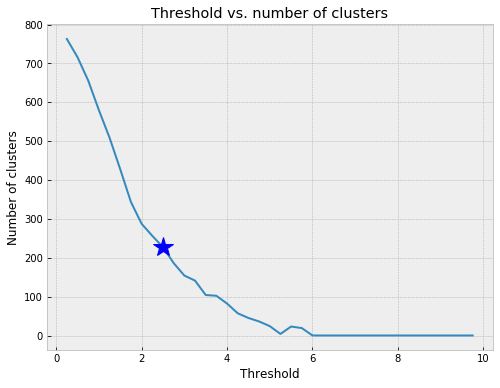

In [13]:
window_size, window_step, order_of_magnitude = (2,0), (0,1), 3 * n_clusters
algorithm, n_clusters_algorithm = 'hierarchical','birch_variable'

###Optimal threshold for the moving windows framework
optimal_threshold = clustlib.threshold_tuning(data=data,
                                    df=transformed_table,
                                    clustering_ranges=clustering_ranges,
                                    weights=optimal_weights,
                                    algorithm=n_clusters_algorithm,
                                    size=window_size,
                                    step=window_step,
                                    test_range=[0.25 + (s/4) for s in range(39)],
                                    order_of_magnitude=order_of_magnitude,
                                    do_print=False)

In [14]:
transformed_table.INCDT_ISSUE_LABEL.value_counts()

not_issue                                                     3179
amyr-ak4qpf                                                    288
ho284-25600                                                     60
2017-jep-mnc-00001320-escar-01                                  46
ne121-27806                                                     40
lo401-28283                                                     37
lo048-27723                                                     32
gp716-27472                                                     28
lo048-27717                                                     23
lt945-26564                                                     22
jz327-25890                                                     18
mq007-26346                                                     18
2017-mpt-mnc-00000566-iscar-01                                  14
ou006-27316                                                     14
mq007-28013                                                   

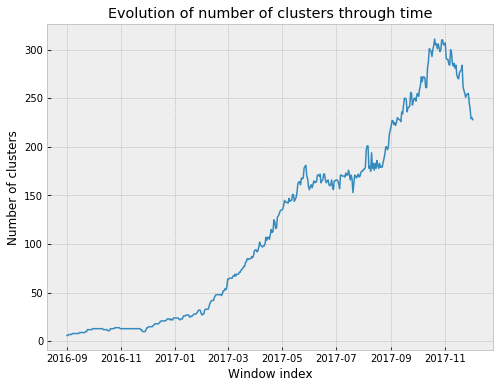

In [15]:
###Perform the clustering
clustering_results, start_window, end_window, anchor = clustlib.moving_windows_framework(data=data,
                                                                                         df=transformed_table,
                                                                                         clustering_ranges=clustering_ranges,
                                                                                         weights=optimal_weights,
                                                                                         size=window_size,
                                                                                         step=window_step,
                                                                                         algorithm=algorithm,
                                                                                         n_clusters_algorithm=n_clusters_algorithm,
                                                                                         threshold=optimal_threshold,
                                                                                         compute_centroids=True,
                                                                                         do_print=False,
                                                                                         do_plot=True)


In [16]:
#Tracking path (range to be tracked)
tracking_path = (0, len(end_window) - 3)

  0%|          | 0/457 [00:00<?, ?it/s]../src/exploration_lib.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

100%|██████████| 457/457 [00:30<00:00, 15.01it/s]


Computing KPI1 over time
Computing KPI2 over time
Computing KPI3 over time
Computing KPI4 over time
Computing Penalization over time


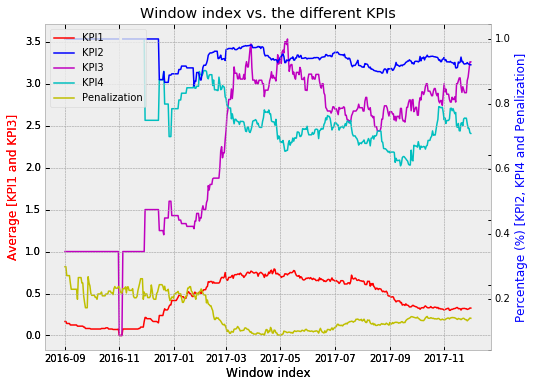

In [17]:
########################################################################################################
#Exploration
##Windows dictionary (optional: convert time complexity to space memory)
windows = explib.map_windows(transformed_table,
                             start_window,
                             end_window,
                             clustering_results,
                             tracking_path)


##Plot KPIs
###All-in-one
# explib.moving_kpis(transformed_table,
#                    start_window,end_window,
#                    clustering_results,
#                    tracking_path,
#                    windows=windows,
#                    combine_plots=True,
#                    kpi2_threshold=0,
#                    kpi3_threshold=0,
#                    kpi4_threshold=0)

#top issues 
top_issues = transformed_table['INCDT_ISSUE_LABEL'].value_counts()[1:21].index

In [18]:
#Perform universal clustering 
universal_ids,universal_labels,universal_anchor = clustlib.get_universal_ids(windows,
                                                                             anchor,
                                                                             clustering_results,
                                                                             tracking_path=tracking_path,
                                                                             tracking_type='reversed_hybrid',
                                                                             centroids_threshold=5.0,
                                                                             count_threshold=0.6,
                                                                             allow_duplicates=True,
                                                                             reassign_duplicates=True)

100%|██████████| 456/456 [20:15<00:00,  2.67s/it]


In [19]:
#Get new clustering_results
transformed_results = clustlib.transform_clustering_results(clustering_results,
                                                            universal_ids,
                                                            tracking_path=tracking_path) 
      
#Get new windows
universal_windows = explib.map_windows(transformed_table,
                                       start_window,
                                       end_window,
                                       transformed_results,
                                       tracking_path)

  0%|          | 0/457 [00:00<?, ?it/s]../src/exploration_lib.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

100%|██████████| 457/457 [05:02<00:00,  1.51it/s]


In [20]:
########################################################################################################
#Reviews
n_new_incidents_per_window, n_reviewed_incidents_per_window, ids_reviewed_incidents, \
    ids_sampled_incidents, detail_review_info, issue_detection_date, detection_date_df = \
    clustlib.describe_reviews(transformed_table,
                             universal_anchor,
                             universal_labels,
                             clustering_features,
                             clustering_ranges,
                             optimal_weights,
                             universal_windows,
                             tracking_path,
                             0.2, 
                             end_window = end_window, 
                             top_issues = top_issues)


  0%|          | 0/457 [00:00<?, ?it/s]/Users/ph697/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1732: RuntimeWarning:

invalid value encountered in double_scalars

100%|██████████| 457/457 [02:24<00:00,  3.16it/s]


# Reviewing Result

### Detection Performance for Top 20 Issues

In [22]:
detection_date_df.sort_values('Number_of_Incidents', ascending = False)

INCDT_ISSUE_LABEL EARLIEST_INDICATION_DATE  \
5                      amyr-ak4qpf               2016-11-30   
7                      ho284-25600               2016-12-30   
2   2017-jep-mnc-00001320-escar-01               2017-03-30   
17                     ne121-27806               2017-04-12   
12                     lo401-28283               2017-06-06   
11                     lo048-27723               2017-06-19   
6                      gp716-27472               2017-03-07   
10                     lo048-27717               2017-05-23   
13                     lt945-26564               2017-03-01   
14                     mq007-26346               2017-02-14   
9                      jz327-25890               2017-01-24   
15                     mq007-28013               2017-05-12   
19                     ou006-27316               2017-02-09   
3   2017-mpt-mnc-00000566-iscar-01               2017-04-19   
16                     ne121-27483               2017-06-12   
18                     nv733-27660               2017-02-01   
4                           504507               2017-04-03   
1                         2017-134               2017-04-12   
8                      ie284-26641               2017-03-20   
0                         14xpi014               2017-05-08   

   EARLIEST_RECORD_DATE      ID Reviewing_Detection_Date  \
5   2016-12-15 00:00:00  467466               2016-12-16   
7   2017-01-09 00:00:00  468646               2017-01-10   
2   2017-04-05 00:00:00  161445               2017-04-06   
17  2017-04-17 00:00:00   80513               2017-04-18   
12  2017-06-28 00:00:00   45852               2017-06-29   
11  2017-06-27 00:00:00  360932               2017-06-28   
6   2017-03-07 11:02:27  201390               2017-03-14   
10  2017-06-05 00:00:00  409724               2017-06-06   
13  2017-03-16 00:00:00  383464               2017-03-17   
14  2017-02-15 00:00:00  303254               2017-02-16   
9   2017-02-03 00:00:00  479062               2017-02-04   
15  2017-05-12 00:00:00   86043               2017-05-13   
19  2017-02-09 00:00:00  134767               2017-02-10   
3   2017-04-21 00:00:00  426780               2017-05-16   
16  2017-06-15 00:00:00  250773               2017-06-16   
18  2017-02-02 00:00:00  359912               2017-02-03   
4   2017-04-04 16:53:03  279086               2017-04-25   
1   2017-04-17 00:00:00  315297               2017-06-13   
8   2017-04-25 00:00:00  416325               2017-04-26   
0   2017-05-09 00:00:00  257485               2017-05-10   

    Detection_Incident_ID  Number_of_Incidents  \
5                  467466                  288   
7                  468646                   60   
2                  161445                   46   
17                  80513                   40   
12                  45852                   37   
11                 360932                   32   
6                  201958                   28   
10                 409724                   23   
13                 383464                   22   
14                 303254                   18   
9                  479062                   18   
15                  86043                   14   
19                 134767                   14   
3                   31895                   14   
16                 250773                   13   
18                 359912                   12   
4                  233298                   11   
1                  188370                   10   
8                  375808                   10   
0                  257485                   10   

    Days_Detected_After_First_Incident  
5                                   16  
7                                   11  
2                                    7  
17                                   6  
12                                  23  
11                                   9  
6                                    7  
10                                  14  
13          

### Number of Top 20 Issues that were detected by their first incident

In [121]:
(detection_date_df.ID == detection_date_df.Detection_Incident_ID).sum()

15

### Total Number of Reviews

In [24]:
np.sum(n_reviewed_incidents_per_window)

947

### Total Number of Incidents

In [25]:
np.sum(n_new_incidents_per_window)

4024

### Average Detection Date for top 20 issues

In [26]:
detection_date_df.Days_Detected_After_First_Incident.mean()

14.0

### detection date for all issues

In [27]:
issue_detection_date

{'14xpi014': '2017-05-10',
 '15xpi018': '2017-07-15',
 '17-0808': '2017-05-24',
 '2016-jep-mnc-00003371-escar-01': '2017-03-30',
 '2017-134': '2017-06-13',
 '2017-136': '2017-10-14',
 '2017-hdm-mnc-00000257-escar-01': '2017-06-21',
 '2017-jep-mnc-00000904-iscar-01': '2017-05-17',
 '2017-jep-mnc-00001320-escar-01': '2017-04-06',
 '2017-jep-pnc-00000032-car-01': '2017-05-11',
 '2017-jes-pnc-00000002-car-01': '2017-02-15',
 '2017-mpt-mnc-00000566-iscar-01': '2017-05-16',
 '25598': '2017-03-31',
 '504507': '2017-04-25',
 '50733': '2017-03-30',
 '53172': '2016-12-30',
 '55695': '2016-12-21',
 '56446': '2017-01-07',
 '56585': '2017-01-06',
 'amyr-ak4qpf': '2016-12-16',
 'bi520-27558': '2017-06-22',
 'cmep-scar-100': '2017-07-19',
 'engine_swing': '2017-04-18',
 'fm449-25706': '2017-02-09',
 'fp296-25244': '2017-09-21',
 'gp716-27472': '2017-03-14',
 'gp716-27473': '2017-02-25',
 'gp716-28293': '2017-09-27',
 'ho284-25600': '2017-01-10',
 'ie284-26641': '2017-04-26',
 'ie284-26675': '2017-03-

### Number of total issues detected

In [28]:
len(issue_detection_date)

57

# Example: what are flagged in one window and what's the reason

In [59]:
detail_review_info['2017-04-18'].query('Action == "Flagged_for_Review"')

ID       ESN REL_CMP_FAIL_CODE_LIST GREEN_WRENCH_FAULT_CODE_LIST  \
48214  385716  79972144                 [ETEB]                 [2375, 2375]   
49764  398118  79965599                 [BKCA]                           []   
10064   80513  79960051                 [ETOB]                   [425, 425]   
19767  158138  79959518                 [EQPE]     [3232, 3232, 4732, 4732]   
48927  391418  79969830                 [EICM]                           []   
36895  295168  79957764           [YNEB, EQPE]     [1887, 1887, 1887, 1887]   

                         REL_OEM_NAME  \
48214        PETERBILT MOTORS COMPANY   
49764     NAVISTAR MEXICO S.A. DE C.V   
10064   VOLVO TRUCKS OF NORTH AMERICA   
19767     NAVISTAR MEXICO S.A. DE C.V   
48927                 KENWORTH RENTON   
36895  BLUE DIAMOND TRUCK S DE R L DE   

                                  GREEN_WRENCH_LIST REL_ANALYSIS_RATE_CAT  \
48214                        [K30123201, K30123201]               X1 2017   
49764                                            []               X3 2017   
10064                        [K39215428, K39215428]               X1 2017   
19767  [K27431463, K27431463, K81572426, K81572426]               X1 2017   
48927                                            []               X3 2017   
36895  [K12024294, K12024294, K20912518, K20912518]               X1 2017   

      REL_CMP_ENGINE_MILES_LIST    REL_CMP_FAIL_DATE_LIST  \
48214                     [7.0]              [2017-04-14]   
49764                  [4400.0]              [2017-04-17]   
10064                  [3243.0]              [2017-04-12]   
19767                  [8288.0]              [2017-04-13]   
48927                   [282.0]              [2017-04-14]   
36895            [721.0, 721.0]  [2017-04-10, 2017-04-10]   

       REL_CMP_SUM_NET_AMOUNT EARLIEST_INDICATION_DATE EARLIEST_RECORD_DATE  \
48214                  225.67               2017-04-14           2017-04-17   
49764                39090.42               2017-04-17           2017-04-17   
10064                  191.35               2017-04-12           2017-04-17   
19767                  196.00               2017-04-12           2017-04-17   
48927                 1074.54               2017-04-14           2017-04-17   
36895                  724.81               2017-04-10           2017-04-17   

      INCDT_ISSUE_LABEL  CLUSTER_ID              Action  \
48214       ho284-25600          68  Flagged_for_Review   
49764      engine_swing         140  Flagged_for_Review   
10064       ne121-27806         141  Flagged_for_Review   
19767       ou006-27316          83  Flagged_for_Review   
48927       amyr-ak4qpf         138  Flagged_for_Review   
36895       ou006-27316         139  Flagged_for_Review   

                                                  Reason  
48214  Belong to Reviewed Cluster but Far away from C...  
49764                       Belong to Unreviewed Cluster  
10064                       Belong to Unreviewed Cluster  
19767  Belong to Reviewed Cluster but Far away from C...  
48927                       Belong to Unreviewed Cluster  
36895                       Belong to Unreviewed Cluster

In [60]:
detail_review_info['2017-05-16'].query('Action == "Flagged_for_Review"')

ID       ESN REL_CMP_FAIL_CODE_LIST  \
3986    31895  79967989                 [USDV]   
14146  113173  79962289                 [ETCT]   
27902  223221  79962120                 [BBEL]   
59686  477493  79962886                 [USDV]   
47979  383840  79970539           [FHAV, FHPH]   

                           GREEN_WRENCH_FAULT_CODE_LIST  \
3986                                 [6255, 3574, 3574]   
14146                                [4151, 4162, 4162]   
27902                                                []   
59686  [6485, 6485, 6485, 6485, 6485, 6485, 6485, 6485]   
47979                                                []   

                         REL_OEM_NAME  \
3986                  KENWORTH RENTON   
14146  BLUE DIAMOND TRUCK S DE R L DE   
27902         KENWORTH MOTOR TRUCK CO   
59686        PETERBILT MOTORS COMPANY   
47979     NAVISTAR MEXICO S.A. DE C.V   

                                       GREEN_WRENCH_LIST  \
3986                   [K81572426, K19251370, K19251370]   
14146                  [K94063501, K14555837, K14555837]   
27902                                                 []   
59686  [K84812048, K90115284, K15000652, K19251370, K...   
47979                                        [K51534094]   

      REL_ANALYSIS_RATE_CAT REL_CMP_ENGINE_MILES_LIST  \
3986                X3 2017                  [7637.0]   
14146               X1 2017                  [7583.0]   
27902               X3 2017                 [22859.0]   
59686               X1 2017                   [893.0]   
47979               X1 2017          [1524.0, 1524.0]   

         REL_CMP_FAIL_DATE_LIST  REL_CMP_SUM_NET_AMOUNT  \
3986               [2017-05-15]                 1150.82   
14146              [2017-05-05]                  760.94   
27902              [2017-05-05]                  168.00   
59686              [2017-05-03]                  767.04   
47979  [2017-05-09, 2017-05-09]                 2622.06   

      EARLIEST_INDICATION_DATE EARLIEST_RECORD_DATE  \
3986                2017-05-15           2017-05-15   
14146               2017-05-06           2017-05-15   
27902               2017-05-05           2017-05-15   
59686               2017-05-03           2017-05-15   
47979               2017-05-12           2017-05-15   

                    INCDT_ISSUE_LABEL  CLUSTER_ID              Action  \
3986   2017-mpt-mnc-00000566-iscar-01         184  Flagged_for_Review   
14146                     amyr-ak4qpf         185  Flagged_for_Review   
27902                       not_issue         187  Flagged_for_Review   
59686                     nv733-27660          59  Flagged_for_Review   
47979                       not_issue         186  Flagged_for_Review   

                                                  Reason  
3986                        Belong to Unreviewed Cluster  
14146                       Belong to Unreviewed Cluster  
27902                       Belong to Unreviewed Cluster  
59686  Belong to Reviewed Cluster but Far away from C...  
47979                       Belong to Unreviewed Cluster

# Review reduction over time

In [39]:
def review_sequence_plt(clustering_time_stamps, baseline_review_number, fully_review_number):
    plt.plot_date([datetime.datetime.strptime(x, '%Y-%m-%d') for x in clustering_time_stamps], 
                  baseline_review_number, ls = 'solid', lw = 1.5, fillstyle = 'none', markersize = 0,
                  label = 'Number of New Incidents')
    plt.plot_date([datetime.datetime.strptime(x, '%Y-%m-%d') for x in clustering_time_stamps], 
                  fully_review_number, ls = 'solid', lw = 1.5, fillstyle = 'none', markersize = 0,
                  label = 'Fully Review All Incidents in Selected Cluster')
    plt.title('Number of Incident Reviews in Each Window')
    plt.legend()
    plt.show()

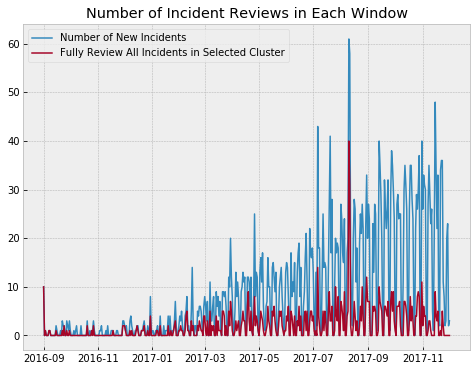

In [40]:
review_sequence_plt([str(x)[:10] for x in end_window[:len(n_reviewed_incidents_per_window)]], 
                    n_new_incidents_per_window, 
                    n_reviewed_incidents_per_window)

# Visualization

In [29]:
#Compute the feature matrix in 2D with T-SNE
X_transformed, transformed_table = explib.tsne_results(transformed_table,
                                                clustering_features,
                                                clustering_ranges,
                                                optimal_weights)

In [30]:
top_clusters = explib.get_top_clusters(tracking_path,
                                        transformed_results,
                                        n=50)

In [31]:
#Compute the windows, display the demo, and save it to working file (demo.html file)
explib.display_2D_demo(top_clusters,
                       universal_windows,
                       tracking_path,
                       X_transformed,
                       transformed_table,
                       end_window)

100%|██████████| 457/457 [00:47<00:00,  9.54it/s]


# Dive deep into certain cluster at certain time

In [48]:
detail_review_info['2017-02-15'].query('CLUSTER_ID == 60')

ID       ESN REL_CMP_FAIL_CODE_LIST GREEN_WRENCH_FAULT_CODE_LIST  \
46230  369848  79954726                 [USDV]                       [3574]   

                      REL_OEM_NAME GREEN_WRENCH_LIST REL_ANALYSIS_RATE_CAT  \
46230  NAVISTAR MEXICO S.A. DE C.V       [K15000652]               X1 2017   

      REL_CMP_ENGINE_MILES_LIST REL_CMP_FAIL_DATE_LIST  \
46230                  [1084.0]           [2017-02-01]   

       REL_CMP_SUM_NET_AMOUNT EARLIEST_INDICATION_DATE EARLIEST_RECORD_DATE  \
46230                 1614.54               2017-02-01           2017-02-14   

                  INCDT_ISSUE_LABEL  CLUSTER_ID              Action  \
46230  2017-jes-pnc-00000002-car-01          60  Flagged_for_Review   

                             Reason  
46230  Belong to Unreviewed Cluster

# Stability: Future of Cluster ID 60

In [82]:
detail_review_info['2017-05-15'].query('CLUSTER_ID == 60')

ID       ESN REL_CMP_FAIL_CODE_LIST  \
6204    49639  79968188                 [USDV]   
29416  235330  79963542                 [USDV]   

               GREEN_WRENCH_FAULT_CODE_LIST                 REL_OEM_NAME  \
6204                                     []  NAVISTAR MEXICO S.A. DE C.V   
29416  [3596, 3596, 3596, 3596, 3488, 3488]  NAVISTAR MEXICO S.A. DE C.V   

                                       GREEN_WRENCH_LIST  \
6204                                                  []   
29416  [K81572426, K81572426, K81572426, K81572426, K...   

      REL_ANALYSIS_RATE_CAT REL_CMP_ENGINE_MILES_LIST REL_CMP_FAIL_DATE_LIST  \
6204                X1 2017                   [291.0]           [2017-05-05]   
29416               X1 2017                  [7597.0]           [2017-04-26]   

       REL_CMP_SUM_NET_AMOUNT EARLIEST_INDICATION_DATE EARLIEST_RECORD_DATE  \
6204                   446.73               2017-05-02           2017-05-05   
29416                  608.96               2017-04-26           2017-04-29   

                    INCDT_ISSUE_LABEL  CLUSTER_ID      Action  \
6204   2017-mpt-mnc-00000566-iscar-01          60  Not_Review   
29416                     jz327-25890          60  Not_Review   

                              Reason  
6204   Old_Incident / Checked_Before  
29416  Old_Incident / Checked_Before

In [80]:
detail_review_info['2017-07-15'].query('CLUSTER_ID == 60')

ID       ESN REL_CMP_FAIL_CODE_LIST GREEN_WRENCH_FAULT_CODE_LIST  \
38140  305121  79969254                 [USDV]                           []   
16610  132882  79959517                 [USDV]                 [3567, 3567]   
58503  468027  79964577                 [USDV]                 [3712, 3712]   
5411    43296  79964095           [USDU, USDV]                           []   
39411  315296  79954186                 [USDV]                           []   

                      REL_OEM_NAME       GREEN_WRENCH_LIST  \
38140  NAVISTAR MEXICO S.A. DE C.V                      []   
16610  NAVISTAR MEXICO S.A. DE C.V  [K25741554, K25741554]   
58503  NAVISTAR MEXICO S.A. DE C.V  [K04082301, K32158833]   
5411   NAVISTAR MEXICO S.A. DE C.V                      []   
39411  NAVISTAR MEXICO S.A. DE C.V                      []   

      REL_ANALYSIS_RATE_CAT REL_CMP_ENGINE_MILES_LIST  \
38140               X1 2017                   [204.0]   
16610               X1 2017                 [17238.0]   
58503               X1 2017                 [12712.0]   
5411                X1 2017        [14216.0, 14216.0]   
39411               X1 2017                  [4300.0]   

         REL_CMP_FAIL_DATE_LIST  REL_CMP_SUM_NET_AMOUNT  \
38140              [2017-05-25]                  380.32   
16610              [2017-04-28]                  580.96   
58503              [2017-05-30]                 1648.36   
5411   [2017-06-06, 2017-06-06]                 2277.45   
39411              [2017-05-19]                  250.47   

      EARLIEST_INDICATION_DATE EARLIEST_RECORD_DATE  \
38140               2017-05-25           2017-06-13   
16610               2017-04-28           2017-05-15   
58503               2017-06-01           2017-06-16   
5411                2017-05-31           2017-07-14   
39411               2017-05-19           2017-05-31   

                    INCDT_ISSUE_LABEL  CLUSTER_ID              Action  \
38140  2017-mpt-mnc-00000566-iscar-01          60          Not_Review   
16610                       not_issue          60          Not_Review   
58503  2017-mpt-mnc-00000566-iscar-01          60          Not_Review   
5411   2017-mpt-mnc-00000566-iscar-01          60  Flagged_for_Review   
39411                       not_issue          60          Not_Review   

                                                  Reason  
38140                      Old_Incident / Checked_Before  
16610                      Old_Incident / Checked_Before  
58503                      Old_Incident / Checked_Before  
5411   Belong to Reviewed Cluster but Far away from C...  
39411                      Old_Incident / Checked_Before

In [87]:
detail_review_info['2017-08-15'].query('CLUSTER_ID == 60')

ID       ESN REL_CMP_FAIL_CODE_LIST GREEN_WRENCH_FAULT_CODE_LIST  \
1958    15665  79967118                 [USDV]                           []   
58503  468027  79964577                 [USDV]                 [3712, 3712]   
5411    43296  79964095           [USDU, USDV]                           []   

                      REL_OEM_NAME       GREEN_WRENCH_LIST  \
1958   NAVISTAR MEXICO S.A. DE C.V                      []   
58503  NAVISTAR MEXICO S.A. DE C.V  [K04082301, K32158833]   
5411   NAVISTAR MEXICO S.A. DE C.V                      []   

      REL_ANALYSIS_RATE_CAT REL_CMP_ENGINE_MILES_LIST  \
1958                X1 2017                 [36944.0]   
58503               X1 2017                 [12712.0]   
5411                X1 2017        [14216.0, 14216.0]   

         REL_CMP_FAIL_DATE_LIST  REL_CMP_SUM_NET_AMOUNT  \
1958               [2017-07-04]                 1501.31   
58503              [2017-05-30]                 1648.36   
5411   [2017-06-06, 2017-06-06]                 2277.45   

      EARLIEST_INDICATION_DATE EARLIEST_RECORD_DATE  \
1958                2017-07-04           2017-07-18   
58503               2017-06-01           2017-06-16   
5411                2017-05-31           2017-07-14   

                    INCDT_ISSUE_LABEL  CLUSTER_ID      Action  \
1958                        not_issue          60  Not_Review   
58503  2017-mpt-mnc-00000566-iscar-01          60  Not_Review   
5411   2017-mpt-mnc-00000566-iscar-01          60  Not_Review   

                              Reason  
1958   Old_Incident / Checked_Before  
58503  Old_Incident / Checked_Before  
5411   Old_Incident / Checked_Before

In [86]:
detail_review_info['2017-11-15'].query('CLUSTER_ID == 60')

ID       ESN REL_CMP_FAIL_CODE_LIST GREEN_WRENCH_FAULT_CODE_LIST  \
34937  279500  79969234                 [USDV]                           []   
24848  198789  79982125                 [USDV]                           []   
54708  437669  79961357                 [USDV]                           []   
38037  304299  79953714                 [USDV]                 [6486, 6486]   

                      REL_OEM_NAME       GREEN_WRENCH_LIST  \
34937  NAVISTAR MEXICO S.A. DE C.V                      []   
24848  NAVISTAR MEXICO S.A. DE C.V                      []   
54708  NAVISTAR MEXICO S.A. DE C.V                      []   
38037  NAVISTAR MEXICO S.A. DE C.V  [K55102811, K55102811]   

      REL_ANALYSIS_RATE_CAT REL_CMP_ENGINE_MILES_LIST REL_CMP_FAIL_DATE_LIST  \
34937               X1 2017                 [62504.0]           [2017-10-19]   
24848               X1 2017                  [5210.0]           [2017-10-18]   
54708               X1 2017                 [59051.0]           [2017-08-22]   
38037               X1 2017                 [61705.0]           [2017-06-22]   

       REL_CMP_SUM_NET_AMOUNT EARLIEST_INDICATION_DATE EARLIEST_RECORD_DATE  \
34937                  226.80               2017-10-19           2017-10-30   
24848                  469.85               2017-10-18           2017-10-27   
54708                  136.00               2017-08-22           2017-09-14   
38037                  720.89               2017-06-23           2017-09-21   

      INCDT_ISSUE_LABEL  CLUSTER_ID      Action                         Reason  
34937         not_issue          60  Not_Review  Old_Incident / Checked_Before  
24848         not_issue          60  Not_Review  Old_Incident / Checked_Before  
54708         not_issue          60  Not_Review  Old_Incident / Checked_Before  
38037         not_issue          60  Not_Review  Old_Incident / Checked_Before

# Another Example

In [115]:
detail_review_info['2017-02-28'].query('CLUSTER_ID == 72')

ID       ESN REL_CMP_FAIL_CODE_LIST GREEN_WRENCH_FAULT_CODE_LIST  \
5242  41940  79964881                 [FHAS]                           []   
4258  34067  79964396           [FHAS, FHAS]                           []   

                 REL_OEM_NAME GREEN_WRENCH_LIST REL_ANALYSIS_RATE_CAT  \
5242  KENWORTH MOTOR TRUCK CO                []               X3 2017   
4258  KENWORTH MOTOR TRUCK CO                []               X3 2017   

     REL_CMP_ENGINE_MILES_LIST    REL_CMP_FAIL_DATE_LIST  \
5242                    [22.0]              [2017-02-26]   
4258              [33.0, 33.0]  [2017-02-24, 2017-02-24]   

      REL_CMP_SUM_NET_AMOUNT EARLIEST_INDICATION_DATE EARLIEST_RECORD_DATE  \
5242                 2206.09               2017-02-27           2017-02-27   
4258                 1608.87               2017-02-27           2017-02-27   

     INCDT_ISSUE_LABEL  CLUSTER_ID              Action  \
5242       mq007-26346          72  Flagged_for_Review   
4258       mq007-26346          72  Flagged_for_Review   

                            Reason  
5242  Belong to Unreviewed Cluster  
4258  Belong to Unreviewed Cluster

In [116]:
detail_review_info['2017-05-28'].query('CLUSTER_ID == 72')

ID       ESN REL_CMP_FAIL_CODE_LIST GREEN_WRENCH_FAULT_CODE_LIST  \
41198  329591  79964954           [FHAS, FHAS]                           []   
41474  331799  79967745                 [FHAS]                           []   
8048    64388  79963083                 [FHAS]                           []   
50472  403779  79963121                 [FHAS]                           []   
24041  192336  79958745                 [FHAS]                           []   
31769  254160  79962842                 [FHAS]                           []   

                  REL_OEM_NAME       GREEN_WRENCH_LIST REL_ANALYSIS_RATE_CAT  \
41198  KENWORTH MOTOR TRUCK CO                      []               X3 2017   
41474  KENWORTH MOTOR TRUCK CO                      []               X3 2017   
8048   KENWORTH MOTOR TRUCK CO  [K83951300, K49875141]               X3 2017   
50472  KENWORTH MOTOR TRUCK CO                      []               X3 2017   
24041  KENWORTH MOTOR TRUCK CO                      []               X3 2017   
31769  KENWORTH MOTOR TRUCK CO                      []               X3 2017   

      REL_CMP_ENGINE_MILES_LIST    REL_CMP_FAIL_DATE_LIST  \
41198              [11.0, 11.0]  [2017-03-24, 2017-03-24]   
41474                  [4778.0]              [2017-05-09]   
8048                     [72.0]              [2017-03-30]   
50472                   [413.0]              [2017-04-21]   
24041                     [0.0]              [2017-03-08]   
31769                  [1056.0]              [2017-04-05]   

       REL_CMP_SUM_NET_AMOUNT EARLIEST_INDICATION_DATE EARLIEST_RECORD_DATE  \
41198                 4541.01               2017-03-24           2017-03-30   
41474                 5281.51               2017-05-09           2017-05-17   
8048                  5264.05               2017-03-30           2017-03-31   
50472                 2053.23               2017-04-22           2017-04-24   
24041                  963.72               2017-03-08           2017-03-29   
31769                 5752.70               2017-04-05           2017-04-05   

      INCDT_ISSUE_LABEL  CLUSTER_ID      Action                         Reason  
41198         not_issue          72  Not_Review  Old_Incident / Checked_Before  
41474         not_issue          72  Not_Review  Old_Incident / Checked_Before  
8048        mq007-26346          72  Not_Review  Old_Incident / Checked_Before  
50472       mq007-26346          72  Not_Review  Old_Incident / Checked_Before  
24041         not_issue          72  Not_Review  Old_Incident / Checked_Before  
31769       mq007-26346          72  Not_Review  Old_Incident / Checked_Before

In [118]:
detail_review_info['2017-08-28'].query('CLUSTER_ID == 72')

ID       ESN REL_CMP_FAIL_CODE_LIST GREEN_WRENCH_FAULT_CODE_LIST  \
27278  218231  79986116                 [FHAS]                       [4691]   
56567  452543  79970072           [FLRS, FHAS]                           []   
38315  306524  79990491                 [FHAS]                           []   
48214  385714  79971822                 [FHAS]                           []   
5411    43293  79962833                 [FHAS]                   [559, 559]   
15354  122840  79959322                 [FHAS]                           []   

                  REL_OEM_NAME       GREEN_WRENCH_LIST REL_ANALYSIS_RATE_CAT  \
27278  KENWORTH MOTOR TRUCK CO             [K13516252]               X3 2017   
56567  KENWORTH MOTOR TRUCK CO                      []               X3 2017   
38315  KENWORTH MOTOR TRUCK CO                      []               X3 2017   
48214  KENWORTH MOTOR TRUCK CO                      []               X3 2017   
5411   KENWORTH MOTOR TRUCK CO  [K71890416, K71890416]               X3 2017   
15354  KENWORTH MOTOR TRUCK CO                      []               X3 2017   

      REL_CMP_ENGINE_MILES_LIST    REL_CMP_FAIL_DATE_LIST  \
27278                    [20.0]              [2017-07-20]   
56567            [522.0, 521.0]  [2017-08-15, 2017-08-15]   
38315                   [100.0]              [2017-08-16]   
48214                  [2281.0]              [2017-08-11]   
5411                   [1169.0]              [2017-07-21]   
15354                     [0.0]              [2017-08-10]   

       REL_CMP_SUM_NET_AMOUNT EARLIEST_INDICATION_DATE EARLIEST_RECORD_DATE  \
27278                    0.00               2017-07-25           2017-08-22   
56567                 2248.68               2017-08-15           2017-08-22   
38315                 2052.76               2017-08-16           2017-08-18   
48214                 2091.28               2017-08-11           2017-08-22   
5411                  2898.09               2017-07-20           2017-08-03   
15354                 1636.46               2017-08-10           2017-08-18   

      INCDT_ISSUE_LABEL  CLUSTER_ID      Action                         Reason  
27278         not_issue          72  Not_Review  Old_Incident / Checked_Before  
56567         not_issue          72  Not_Review  Old_Incident / Checked_Before  
38315         not_issue          72  Not_Review  Old_Incident / Checked_Before  
48214         not_issue          72  Not_Review  Old_Incident / Checked_Before  
5411        mq007-26346          72  Not_Review  Old_Incident / Checked_Before  
15354         not_issue          72  Not_Review  Old_Incident / Checked_Before

In [120]:
detail_review_info['2017-11-28'].query('CLUSTER_ID == 72')

ID       ESN REL_CMP_FAIL_CODE_LIST GREEN_WRENCH_FAULT_CODE_LIST  \
46178  369431  79999819           [FHAS, NRPR]         [559, 559, 559, 559]   
10064   80520  79972096                 [FHAS]                           []   
31085  248688  79971307           [FHAS, FHAS]                           []   
41653  333232  79961396           [FHAS, FHAS]                           []   

                  REL_OEM_NAME                             GREEN_WRENCH_LIST  \
46178  KENWORTH MOTOR TRUCK CO  [K71890416, K71890416, K71890416, K71890416]   
10064  KENWORTH MOTOR TRUCK CO                                            []   
31085  KENWORTH MOTOR TRUCK CO                                            []   
41653  KENWORTH MOTOR TRUCK CO                                            []   

      REL_ANALYSIS_RATE_CAT REL_CMP_ENGINE_MILES_LIST  \
46178               X3 2017            [873.0, 873.0]   
10064               X3 2017                 [14011.0]   
31085               X3 2017        [11010.0, 11010.0]   
41653               X3 2017        [34388.0, 34388.0]   

         REL_CMP_FAIL_DATE_LIST  REL_CMP_SUM_NET_AMOUNT  \
46178  [2017-10-01, 2017-10-01]                 2208.23   
10064              [2017-09-15]                 2266.53   
31085  [2017-10-08, 2017-10-08]                 2564.59   
41653  [2017-09-15, 2017-09-15]                 1894.76   

      EARLIEST_INDICATION_DATE EARLIEST_RECORD_DATE INCDT_ISSUE_LABEL  \
46178               2017-10-01           2017-10-10         not_issue   
10064               2017-09-15           2017-10-18         not_issue   
31085               2017-10-08           2017-10-12         not_issue   
41653               2017-09-15           2017-09-27         not_issue   

       CLUSTER_ID      Action                         Reason  
46178          72  Not_Review  Old_Incident / Checked_Before  
10064          72  Not_Review  Old_Incident / Checked_Before  
31085          72  Not_Review  Old_Incident / Checked_Before  
41653          72  Not_Review  Old_Incident / Checked_Before

# Large Clusters are mostly not issues

## Most of the fail code and fault code is missing, so we can only separate by X1/X3 and OEM to monitor its growth

In [62]:
explib.universal_characterization(transformed_table,
                               clustering_features,
                               universal_windows,
                               tracking_path,
                               24,
                               treshold_top=1,
                               treshold_bottom=1)

REL_OEM_NAME_NAVISTAR MEXICO S.A. DE C.V    1.684173
dtype: float64

In [68]:
detail_review_info['2017-10-15'].query('CLUSTER_ID == 24').INCDT_ISSUE_LABEL.value_counts()

not_issue      160
2017-134         1
ie284-26641      1
ho284-25600      1
ne121-27492      1
Name: INCDT_ISSUE_LABEL, dtype: int64

In [63]:
explib.universal_characterization(transformed_table,
                               clustering_features,
                               universal_windows,
                               tracking_path,
                               44,
                               treshold_top=1,
                               treshold_bottom=1)

REL_OEM_NAME_PETERBILT MOTORS COMPANY    1.743216
REL_ANALYSIS_RATE_CAT_X3                 1.216149
REL_ANALYSIS_RATE_CAT_X1                -1.215522
dtype: float64

In [66]:
detail_review_info['2017-10-15'].query('CLUSTER_ID == 44').INCDT_ISSUE_LABEL.value_counts()

not_issue      66
14xpi014        1
lo401-28283     1
lo048-27717     1
gp716-27472     1
ne121-27483     1
lo048-27723     1
ne121-27493     1
Name: INCDT_ISSUE_LABEL, dtype: int64

In [70]:
explib.universal_characterization(transformed_table,
                               clustering_features,
                               universal_windows,
                               tracking_path,
                               19,
                               treshold_top=1,
                               treshold_bottom=1)

REL_OEM_NAME_KENWORTH MOTOR TRUCK CO    1.522565
dtype: float64

In [67]:
detail_review_info['2017-10-15'].query('CLUSTER_ID == 19').INCDT_ISSUE_LABEL.value_counts()

not_issue      76
mf470-28200     1
Name: INCDT_ISSUE_LABEL, dtype: int64

In [71]:
explib.universal_characterization(transformed_table,
                               clustering_features,
                               universal_windows,
                               tracking_path,
                               38,
                               treshold_top=1,
                               treshold_bottom=1)

REL_OEM_NAME_KENWORTH MOTOR TRUCK CO    1.506850
REL_ANALYSIS_RATE_CAT_X3                1.216149
REL_ANALYSIS_RATE_CAT_X1               -1.215522
dtype: float64

In [69]:
detail_review_info['2017-10-15'].query('CLUSTER_ID == 38').INCDT_ISSUE_LABEL.value_counts()

not_issue      125
lo048-27723      2
lo401-28283      1
Name: INCDT_ISSUE_LABEL, dtype: int64